In [43]:
!pip install git+https://github.com/Breno-st/ds-utils.git

  Cloning https://github.com/Breno-st/ds-utils.git to c:\users\b_tib\appdata\local\temp\pip-req-build-c6qfe2m3
  Created wheel for ensemble: filename=ensemble-0.1-py3-none-any.whl size=1056 sha256=3b67d34af925f710035b0d28325a304bdbaf76ee018a786a4c05ddf02df87f7c
  Stored in directory: C:\Users\b_tib\AppData\Local\Temp\pip-ephem-wheel-cache-d1rd4h5v\wheels\0e\fb\8a\9c1e552752417e45ef056479c772e6b04146550c654c3f9e17
Successfully built ensemble
  Running command git clone -q https://github.com/Breno-st/ds-utils.git 'C:\Users\b_tib\AppData\Local\Temp\pip-req-build-c6qfe2m3'


In [44]:
!pip install git+http://github.com/brendanhasz/dsutils.git


  Cloning http://github.com/brendanhasz/dsutils.git to c:\users\b_tib\appdata\local\temp\pip-req-build-ogoo5wbb
  Created wheel for dsutils: filename=dsutils-0.1-py3-none-any.whl size=44066 sha256=7216cb6b557de5020fc5b8eeaedacd1e9efbb8c430c44f0ff25ec0439a52bdd0
  Stored in directory: C:\Users\b_tib\AppData\Local\Temp\pip-ephem-wheel-cache-mggm7j4i\wheels\ab\b0\69\592ce66f02b9cc72e3e0419119d5688e56ce89adb60ea7ce13
Successfully built dsutils


In [42]:
from dsutils.optimization import optimize_params
from ensemble.bootstrapped_aggregation import BaggingTrees

ModuleNotFoundError: No module named 'ensemble'

## Importing libraries...

In [2]:
import pickle

import numpy as np
import pandas as pd
import string
import itertools
from itertools import combinations
from itertools import product
import collections 
from collections import Counter

# models
from sklearn import  svm
from sklearn.tree import DecisionTreeClassifier

# Feature selection
from sklearn import feature_selection
from sklearn import preprocessing,  svm
from sklearn.cluster import AffinityPropagation

# validation
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# vizualization
import matplotlib.pyplot as plt



## Some function to help on data cleaning/processing...

In [3]:
# AUXILIARY FUNCTIONS


## FOR CATEGORIES:
def alpha_views(dataframe, views_ref=None):
    
    df = dataframe.copy()
    cols = df.columns
    column_values = df.values.ravel()
    unique_values =  pd.unique(column_values)
    
    if not views_ref:
        Training = True
        alpha = {}
        for value, label in zip(unique_values, product_gen(string.ascii_uppercase)):
            alpha[value] = label    

        for col in cols:
            df.replace({col: alpha}, inplace = True)

        return df, alpha
    
    # Rename test views according to views_ref
    diff_views = [i for i in list(views_ref) + unique_values.tolist() if i not in views_ref.keys()]
    upd_views = list(views_ref) + diff_views
    alpha = {}
    for value, label in zip(upd_views, product_gen(string.ascii_uppercase)):
            alpha[value] = label    

    for col in cols:
        df.replace({col: alpha}, inplace = True)
    return df

def product_gen(n):
    '''
    Code reference:
    https://stackoverflow.com/questions/6412473/python-assign-letter-of-the-alphabet-to-each-value-in-a-list'''
    
    for r in itertools.count(1):
        for i in itertools.product(n, repeat=r):
            yield "".join(i)


def dict_categ_sequences(sequence, cluster_ref=None, damping=None):
    ''' Return a dictionaire clustering strings listed by levenshtein-distancing. 
    Code reference:
    https://stats.stackexchange.com/questions/123060/clustering-a-long-list-of-strings-words-into-similarity-groups '''
    
    if not cluster_ref:
        Training = True
         ## Affinity clustering by string distance  
        sequence = np.asarray(sequence)
        lev_similarity = -1*np.array([[distance.levenshtein(w1, w2) for w1 in sequence] for w2 in sequence])
        affprop = AffinityPropagation(affinity="precomputed", damping=damping) ## To explore
        affprop.fit(lev_similarity)
       
        ## Run dictionaire d        
        d = {}  
        i = 0
        exemplars = []
        for cluster_id in np.unique(affprop.labels_):
            exemplar = sequence[affprop.cluster_centers_indices_[cluster_id]]
            cluster = np.unique(sequence[np.nonzero(affprop.labels_==cluster_id)])
            exemplars.append(exemplar)        
            key = 'seq_' + str(i)
            d[key] = cluster
            i += 1
                
        ## Assembling output from d
        newdict = {}
        newdict = {i: k for k, v in d.items() for i in v}   
        
        return newdict, exemplars
    
    else:  
        
        # for each sequence, calculate the closest reference
        reference_list = [ cluster_ref[np.argmin([distance.levenshtein(w1, w2) for w1 in cluster_ref])] for w2 in sequence]
        
        # create a dictionaire with reference "keys" and sequence "values"
        dct ={k:[x for id,x in enumerate(sequence) if k == reference_list[id]] for k in reference_list}
        
        # Add missing references to dct and rename keys to seq_():
        new_dct ={}
        for i, cluster in enumerate(cluster_ref):
            if cluster in dct.keys():
                new_dct['seq_'+str(i)] = dct[cluster]
            else:
                new_dct['seq_'+str(i)] = []
                
        # assembling output form new_dct
        newdict = {} 
        newdict = {i: k for k, v in new_dct.items() for i in v}  
        
        return newdict


def new_categ_features(df, cluster_ref=None, Training=True, damping=0.98):       
    '''Generates new features based on the task interpretation'''       
    
    dataframe = df.copy()
    
    if cluster_ref:
        Training = False
    ## Redudancy
    dataframe['not_na'] = dataframe.apply(lambda x: x.count()/6, axis=1)    
    
    ## Diversity
    dataframe['diversity'] = [len(set(v[pd.notna(v)]))/6 for v in dataframe.iloc[:,:-1].values]   
            
    if Training:
        ## Sequence
        dataframe['sequence'] = dataframe[dataframe.columns[:6]].apply(lambda x: ''.join(x.dropna().astype(str)), axis=1)
        sequences = dataframe['sequence'].values
        newdict, keys = dict_categ_sequences(sequences, damping=damping)
        dataframe['seq_categ'] = dataframe.sequence.str.findall('|'.join(newdict.keys())).str[0].map(newdict)        
        
        ## Diversity factor
        dataframe['divesity_factor'] = round(dataframe.diversity * dataframe.not_na,2)        
        ## Drop auxiliars columns
        dataframe = dataframe.drop(['diversity', 'not_na', 'sequence'], axis=1)
                
        return dataframe, keys
        
    else:
        ## Sequence
        dataframe['sequence'] = dataframe[dataframe.columns[:6]].apply(lambda x: ''.join(x.dropna().astype(str)), axis=1)
        sequences = set(dataframe['sequence'].values)
        newdict = dict_categ_sequences(sequences, cluster_ref)
        dataframe['seq_categ'] = dataframe.sequence.str.findall('|'.join(newdict.keys())).str[0].map(newdict)   
        
        ## Diversity factor
        dataframe['divesity_factor'] = round(dataframe.diversity * dataframe.not_na,2)
        ## Drop auxiliars columns
        dataframe = dataframe.drop(['diversity', 'not_na', 'sequence'], axis=1)        
    
        return dataframe

def dummy_new_features(dataframe, valid_cols=None, Training = True):
    '''Convert new created categories into dummy variables'''
    dm_dataframe = dataframe.copy()
    
    if valid_cols is not None:
        Training = False
    
    if Training:        
        dm_dataframe = pd.get_dummies(dataframe.iloc[:,:-1].astype(str), prefix='', prefix_sep='').max(level=0, axis=1)
        dm_dataframe = dm_dataframe.reindex(sorted(dm_dataframe.columns), axis=1)
        dm_dataframe['divesity_factor'] = dataframe['divesity_factor']
        dm_dataframe = dm_dataframe.iloc[:,:-1].multiply(dm_dataframe['divesity_factor'], axis="index")
        dm_dataframe['divesity_factor'] = dataframe.divesity_factor*6
        
        return dm_dataframe, dm_dataframe.iloc[:,:-1].columns
        
    else:
        dm_dataframe = pd.get_dummies(dataframe.iloc[:,:-1].astype(str), prefix='', prefix_sep='').max(level=0, axis=1)
        dm_dataframe = dm_dataframe.reindex(sorted(dm_dataframe.columns), axis=1)        
        test_cols = dm_dataframe.columns        
        # list columns to remove (which are in  test_cols no in training_views values):
        to_drop = []
        for col in test_cols:
            if 'seq_' not in col:
                if col not in valid_cols:
                    to_drop.append(col)
        dm_dataframe = dm_dataframe.drop(to_drop, axis=1)
        # list columns to add (which are not in test_cols but in training_views values):
        to_add = []
        for col in valid_cols:
            if col not in test_cols:
                dm_dataframe[col] = 0
                
        dm_dataframe = dm_dataframe.reindex(sorted(dm_dataframe.columns), axis=1)
        dm_dataframe['divesity_factor'] = dataframe['divesity_factor']
        dm_dataframe = dm_dataframe.iloc[:,:-1].multiply(dm_dataframe['divesity_factor'], axis="index")
        dm_dataframe['divesity_factor'] = dataframe.divesity_factor*6
        
    return dm_dataframe

## FOR SCALARS:
def list_constant_columns(dataframe): 
    '''List columns with no variance'''
    to_drop = []
    result = dataframe.copy()
    for column in dataframe.columns:
        
        if dataframe[column].std() == 0:
            to_drop.append(column)
    return to_drop

def list_lcorr_columns(dataframe, threshold=0.1):
    '''List columns with 'Label-Correlation' lower than threshold'''
    to_drop = []
    for col in dataframe.columns:
        corr = dataframe[col].corr(dataframe['labels'])
        if abs(corr) < threshold:
            to_drop.append(col)
    return to_drop


def replace_nan_norm(dataframe, norm_list=None, Training=True):
    '''Replace Nan values and normalize according to the training set'''
    df = dataframe.copy()

    if norm_list:
        Training = False
        
    if Training:
        norm_list = []
        for col in df.iloc[:,:-1].columns:
            mean = np.nanmean(df[col]) 
            std = np.std(df[col])
            df[col] = df[col].fillna(mean)
            df[col] =(df[col]-mean )/std            
            norm_list.append([mean, std])
            
        return df, norm_list
        
    else:
        assert dataframe.shape[1] == len(norm_list), 'Different sizes: df={} meanlist={} size board.'.format(dataframe.shape[1], len(mean_list))
        for id, col in enumerate(df.columns):
            df[col] = df[col].fillna(norm_list[id][0])
            df[col] = (df[col]-norm_list[id][0] )/norm_list[id][1]
            
        return df

## Importing the datasets...

In [72]:
test_data = pickle.load(open("C:/Users/b_tib/coding/Msc/oLINGI2262/Inginious_task_5/test.pickle", "rb"))
(train_data_1, train_labels_1) = pickle.load(open("C:/Users/b_tib/coding/Msc/oLINGI2262/Inginious_task_5/train1.pickle", "rb"))
(train_data_2, train_labels_2) = pickle.load(open("C:/Users/b_tib/coding/Msc/oLINGI2262/Inginious_task_5/train2.pickle", "rb"))

## Splitting categorical and scalar values ...

In [73]:
# MERGING 1 & 2:
train_data = train_data_1.append(train_data_2)
train_labels =np.concatenate((train_labels_1, train_labels_2), axis=None)

# SEPARTING SCALAR:
train_data_scalar = train_data.iloc[:,:1306624]
test_data_scalar = test_data.iloc[:,:1306624] # Test (no labels)
#train_data_scalar['labels'] = train_labels

## Categories
train_data_categ_raw = train_data.iloc[:,1306624:]
test_data_categ_raw= test_data.iloc[:,1306624:] # Test

## Processing ....
### 1) Divide dataframe into subsets by:
#### - Damping categorical according to damping coeficients
#### - Renmoving columns with low target-correlation according to threshold
### 2) Concatenate damping/thresholds subsets into dct_subsets:
#### - Store possible pairwises into a dictionaire
#### - For each pairwise, run most importante features (run in google colab)
### 3) Run the most relevant features for each dct_subsets and stored in dct_features:

In [ ]:


# THIS STEP WAS COMPUTED IN GOOGLE COLAB
# THE MOST IMPORTA COLUMNS NAMES ARE STORED IN "dct_features".HOWEVER, THERE IS MORE...
# THE FUNCTION REPLAN NAN AND NORMILIZE EXTEND TRAIN-SET KNOWNLEDGE TO TEST-SET BEFORE PREDICTION 

# PROCESSING CATEGORIES
dampings = [0.9] #  0.95, 0.98
dct_categ = {}
for damping in dampings:
  try:
      ## Convert views into alphabethic variable for distancing
      train_data_angles, training_views = alpha_views(train_data_angles) # for colab: remove "-" 
      test_data_angles = alpha_views(test_data_angles, training_views) # for colab: remove "-" 

      ## Applying edit-distancing and clustering using AffinityPropagation
      nf_train_data_angles, keys = new_categ_features(train_data_angles, damping=damping) 
      nf_test_data_angles = new_categ_features(test_data_angles, keys)

      ## Converting new categories in dummy variables
      train_data_categ, valid_columns = dummy_new_features(nf_train_data_angles) 
      test_data_categ = dummy_new_features(nf_test_data_angles, valid_cols=valid_columns)

      dct_categ[damping] = [train_data_categ, test_data_categ]
      
  except Exception:
      pass  # or you could use 'continue'

# PROCESSING SCALARS

thresholds = [0.1] #0.2, 0.3
dct_scalar = {}
for threshold in thresholds:
  try:
      ## listing columns to drop based on low correlation threshold based on train-set:
      drop_constants = list_constant_columns(train_data_vector) # for colab: remove "-" 
      drop_low_corr = list_lcorr_columns(train_data_vector, threshold = threshold) # for colab: remove "-"  

      ## Dropping columns to drop based on low correlation threshold:
      dp_train_data_vector = train_data_vector.drop(drop_constants, axis=1) # for colab: remove "-" 
      dp_train_data_vector = dp_train_data_vector.drop(drop_low_corr, axis=1)

      dp_test_data_vector = test_data_vector.drop(drop_constants, axis=1) # for colab: remove "-" 
      dp_test_data_vector = dp_test_data_vector.drop(drop_low_corr, axis=1)

      ## Replacing Nan values and normalizing columns based on train-set:
      train_data_scalar, norm_list = replace_nan_norm(dp_train_data_vector)
      test_data_scalar = replace_nan_norm(dp_test_data_vector, norm_list=norm_list)

      dct_scalar[threshold] = [train_data_scalar, test_data_scalar]

  except Exception:
      pass  # or you could use 'continue'


# Concatenating train and test SUBSETS
dct_subsets = {}
for k_categ, v_categ in dct_categ.items():
  for k_scalar, v_scalar in dct_scalar.items():
    # merger keys
    k_db = str(k_categ) + '_' + str(k_scalar)

    # merge values
    dct_subsets[k_db] = [pd.concat([v_categ[0], v_scalar[0]], axis=1), pd.concat([v_categ[1], v_scalar[1]], axis=1)]


# Passing dataframe through Decision tree importance and getting most significant features for each. 
dct_features = {}

for k, v in dct_subsets.items():

  train = v[0]

  # DECISION TREE Best Features
  x_train = train.iloc[:,:-1]
  Y_train = train.iloc[:,-1:]
  clf = DecisionTreeClassifier(random_state=0)
  clf = clf.fit(x_train, Y_train)
  dct= dict(zip(x_train.columns, clf.feature_importances_))
  dct = {k: v for k, v in sorted(dct.items(), key=lambda item: item[1], reverse=True)}
  features = {x:y for x,y in dct.items() if y!=0}
  if features not in dct_features.values():
    dct_features[k] = features

## Feature Selection ...
### - Apply damping, thresholds and relevant features for a clean experiemntal databases.
### - Using raw (train/test) data, remember to replace Nan by the mean only (standardization during the cross validations).
### - *In the raw test data, the Nan replacements is according to train data mean. 


In [74]:
dct_databases = {}
i=0


for k, v in dct_features.items():
    
    damping = float(k.split('_')[0])
    threshold = float(k.split('_')[1])
    
    # PROCESSING CATEGORIES

    ## Convert views into alphabethic variable for distancing
    train_data_angles, training_views = alpha_views(train_data_categ_raw) 
    test_data_angles = alpha_views(test_data_categ_raw, training_views) 

    ## Applying edit-distancing and clustering using AffinityPropagation
    nf_train_data_angles, keys = new_categ_features(train_data_angles, damping=damping) # v.split('_')[0]
    nf_test_data_angles = new_categ_features(test_data_angles, keys)

    ## Converting new categories in dummy variables
    train_data_categ, valid_columns = dummy_new_features(nf_train_data_angles) 
    test_data_categ = dummy_new_features(nf_test_data_angles, valid_cols=valid_columns)
    
    # MERGING CATEGORIES & SCALARS    
    x_train = pd.concat([train_data_categ, train_data], axis=1) # merges into train data because the scalar will be selected autommaticalli by the features
    x_test = pd.concat([test_data_categ, test_data], axis=1) # merges into train data because the scalar will be selected autommaticalli by the features
    

    # FEATURE SELECTION ON RAW DATA 
    x_train = x_train[v]
    x_test = x_test[v]
    

    # SELECT FEATURES PROCESSING: Remove Nan & ""NOT"" Normalize    
    x_train, mean_list = replace_nan(x_train)
    x_test = replace_nan(x_test, mean_list=mean_list)
    Y_train = train_labels 

    
    # check all columns are equal between x_train & x_test
    assert x_train.columns.all() == x_test.columns.all(), 'train={} and test={} columsn are different.'.format(x_test.shape[1], x_test.shape[1])
    
    dct_databases[i] = [damping, threshold, x_train, Y_train, x_test]
    i += 1
    
    
    print('x_train:',x_train.shape)
    print('\tThe number of missing Values:',x_train.isna().sum().sum())
    print('\tThe average number of missing Values for each attribute:',np.mean(x_train.isnull().sum()))
    print('\tThe standard deviation of the average number of missing Values for each attribute:',np.std(x_train.isnull().sum()))

    print('x_test:',x_test.shape)
    print('\tThe number of missing Values:',x_test.isna().sum().sum())
    print('\tThe average number of missing Values for each attribute:',np.mean(x_test.isnull().sum()))
    print('\tThe standard deviation of the average number of missing Values for each attribute:',np.std(x_test.isnull().sum()))


0.8 0.1
C:\Users\b_tib\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "
x_train: (309, 20)
	The number of missing Values: 0
	The average number of missing Values for each attribute: 0.0
	The standard deviation of the average number of missing Values for each attribute: 0.0
x_test: (103, 20)
	The number of missing Values: 0
	The average number of missing Values for each attribute: 0.0
	The standard deviation of the average number of missing Values for each attribute: 0.0
0.8 0.2
C:\Users\b_tib\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to 

# From here...

1) Store classes as libraries <----

2) Create "Second" Bag Class (SVC) and test Single CV 

3) Create Double (Model comparisson) Nested-CV

4) Convert Single/Double Nested-CV into class

5) Create a classifier inherates bag classes:  self.super()/decide prediction by votes



## Models

In [4]:
class BaggingTrees:
    """Expand the subset of features in regards each node split for
    a more flexible tunning.

    Parameters
    ----------
    X_t : np.array
        Training set features.
    Y_t : np.array
        Training set labels.
    X_v : np.array
        Validation set features.
    p : list
            0: epochs
            1: n_trees
            2: criterion
            3: min_samples_leaf
            4: max_depth
            5: min_samples_splits
            6: max_leaf_nodes
    Output
    -------
    y_pred:      predictions on validation set X_v (array)
    unan_rates:  rate of majority votes (array)
    acc:         accuracy on training set Y_t (integer)
    f1:          f1 score on training set Y_t (integer)
    """
        
    def __init__(self, p):

        # store parameters   
        self.epochs = p[0]; self.n_trees = p[1]
        self.criterion = p[2]; self.min_samples_leaf = p[3]
        self.max_depth = p[4]; self.min_samples_splits = p[5]
        self.max_leaf_nodes = p[6]    
        
        
    def fit(self, X_t, Y_t):
        
        if isinstance(X_t,np.ndarray):
            X_t = pd.DataFrame(X_t)
        elif not isinstance(X_t,pd.core.frame.DataFrame):
            raise Exception('Wrong type for X_t. Expected np.ndarray or pd.DataFrame')

        if isinstance(Y_t,np.ndarray):
            Y_t = pd.DataFrame(Y_t)
        elif not isinstance(X_v,pd.core.frame.DataFrame):
            raise Exception('Wrong type for Y_t. Expected np.ndarray or pd.DataFrame')

        self.X_t_df = X_t.copy(); self.Y_t_df = Y_t.copy()

        X_t['label'] = Y_t
        train_df = X_t
        for i in range(self.epochs):
            self.bag = []
            for run in np.arange(self.n_trees):            
                # resampling the dataframe (number of distinct, number of distinct)
                train_df_bs = train_df.iloc[np.random.randint(len(train_df), size=len(train_df))]
                X_train = train_df_bs.iloc[:,:-1]
                Y_train = train_df_bs.iloc[:,-1:]
                # Storing each trained tree
                wl = DecisionTreeClassifier(criterion=self.criterion
                                        , min_samples_leaf=self.min_samples_leaf
                                        , max_depth=self.max_depth
                                        , min_samples_split=self.min_samples_splits
                                        , max_leaf_nodes=self.max_leaf_nodes).fit(X_train,Y_train) 
                                        #, random_state=run  
                # add tree into bag
                self.bag.append(wl)

        ## Score on Training set
        t_predictions = []
        for i in range(self.n_trees):        
            tree_t_prediction = self.bag[i].predict(self.X_t_df) # predict validation and training sets   
            t_predictions.append(tree_t_prediction) # Append predictions
        
        # Convert predictions lists into np.array to transpose them and obtain "n_tree" predictions per line
        t_predictions_T = np.array(t_predictions).T

        t_final_predictions = []
        # for each entry "m" of X_t_df(m x features)
        for line in t_predictions_T:
            # countabilize the "n_tree" votes in v_predictions_T (m x n_tree)
            most_common = Counter(line).most_common(1)[0][0]
            t_final_predictions.append(most_common) 

        # accuracies values
        self.acc = accuracy_score(self.Y_t_df, t_final_predictions)
        self.f1 = f1_score(self.Y_t_df, t_final_predictions, average='macro')
        self.bcr = balanced_accuracy_score(self.Y_t_df, t_final_predictions)
        self.auc = roc_auc_score(self.Y_t_df, t_final_predictions, average='macro')
        return 
            
    def predict(self, X_v): 

        if isinstance(X_v,np.ndarray):
            X_v = pd.DataFrame(X_v)
        elif not isinstance(X_v,pd.core.frame.DataFrame):
            raise Exception('Wrong type for X_v. Expected np.ndarray or pd.DataFrame')

        self.X_v_df = X_v.copy()
        ## Prediction on Validation set
        v_predictions = []
        # each tree will make a prediction about test_df
        for i in range(self.n_trees):
            tree_v_prediction = self.bag[i].predict(self.X_v_df) # predict validation and training sets
            v_predictions.append(tree_v_prediction) # Append predictions
        # Convert predictions lists into np.array to transpose them and obtain "n_tree" predictions per line
        v_predictions_T = np.array(v_predictions).T
        
        self.prediction = []   
        self.votes = [] 
        # for each entry "n" of X_v_df(n x features)
        for line in v_predictions_T:
            # countabilize the "n_tree" votes in v_predictions_T (n x n_tree) 
            most_common = Counter(line).most_common(1)[0][0]
            unanimity_rate = Counter(line)[most_common] / len(line)
            # get prediction and unanimity rate
            self.prediction.append(most_common)
            self.votes.append(unanimity_rate)
        return self.prediction
        



## Validations

In [160]:
###########################################################################
# * FINISH SINGLE-MODEL NESTED AND THEM ADD THE DOUBLE-MODEL NESTE
# ** AFTER MODIFIED THE BAGGIN INTO CLASS, MAKE CV-NESTED GENERICAL 
##########################################################################

def nested_single_cv(x_t, y_t, L, grid, k_ext, k_int):
    """   
    Help set a hyper-parameters list for a given model before makes 
    its comparison with others hyper-parameterized models.
        
    Input: 
        - x_t: features train (numpy.arrays)
        - y_t: labels train (numpy.arrays)
        - L: learning algorithm (class method .predict())
        - grid: keys as a parameter name; values as the array of the parameter' values (dict)        
        - K_ext: number of external folds (integer) 
        - K_int: number of internal folds (integer)

    Output:        
        - inner_result_frame: index: [k_ext], columns: [hp_set], values: [v_bcr_(k_int_mean)]
        - outter_result_frame: index: [k_ext, hp_hat], columns:[t_bcr, v_bcr], values:[t_bcr, v_bcr]
        - outter_result_aggre: index: [hp_hat], columns:[t_bcr_(ext_mean), v_bcr_(ext_mean), v_bcr_(ext_std)]
    """
    
    hp_set = [v for v in product(*grid.values())]

    inner_results = pd.DataFrame(columns = hp_set)

    outter_results = pd.DataFrame(columns = ['hp_hat' 
                                        , 't_bcr'
                                        , 'v_bcr'
                                        ])

    
    # frame pointer
    i = 0
    # partionate "training rows" into "K_ext" sets   
    K_ext_folds = KFold(n_splits = k_ext, shuffle=False).split(x_t)  # (markers t_i, v_i)
    for t_ext_fold, v_ext_fold in K_ext_folds:
        # sectioning "train set" between "S_k" into "ext_fold" sets            
        x_S_k = x_t[t_ext_fold] # training x
        y_S_k = y_t[t_ext_fold] # training y            
        x_ext_fold = x_t[v_ext_fold] # test x 
        y_ext_fold = y_t[v_ext_fold] # test y
        
        # get hp_hat in the inner loop
        hp_dic = {}
        for idx, hp in enumerate(hp_set):  
            hp_dic[idx]=[]
            # partionate "S_k training rows" into "K_int" sets
            K_int_folds = KFold(n_splits = k_int, shuffle=False).split(x_S_k)   
            for t_int_fold, v_int_fold in K_int_folds:
                # sectioning "S_k" between "Ss_k" into "int_fold" sets                
                x_Ss_k = x_S_k[t_int_fold] # training x
                y_Ss_k = y_S_k[t_int_fold] # training y  
                x_int_fold = x_S_k[v_int_fold] # test x
                y_int_fold = y_S_k[v_int_fold] # test y
                
                # must scaler after partition, for specific a training normalization
                min_max_scaler = MinMaxScaler(feature_range=(0, 1))
                X_t = min_max_scaler.fit_transform(x_Ss_k)
                X_v = min_max_scaler.fit_transform(x_int_fold)
                Y_t = y_Ss_k
                Y_v = y_int_fold
                
                # Loading and fitting model
                model = L(hp)
                model.fit(X_t, Y_t)
                # prediction
                Y_v_predicted = model.predict(X_v)             
                # validation
                v_bcr = balanced_accuracy_score(Y_v, Y_v_predicted)
                # append all 
                hp_dic[idx].append(v_bcr)
        # # Averages the k_int iteractions for each hp in hp_set and stores it
        inner_results.loc[i] = [sum(arr) / len(arr) for arr in hp_dic.values()]

        
        # avg all hp predictions scores and define the higher to hp_hat
        ixd_max= max([(k,np.mean(v)) for k,v in hp_dic.items()],key=lambda item:item[1])[0]
        hp_hat = hp_set[ixd_max]  

        
        # must scaler after partition, for specific a training normalization
        min_max_scaler = MinMaxScaler(feature_range=(0, 1))
        X_t = min_max_scaler.fit_transform(x_S_k)
        X_v = min_max_scaler.fit_transform(x_ext_fold)
        Y_t = y_S_k
        Y_v = y_ext_fold

        # Loading and fitting model
        model = L(hp)
        model.fit(X_t, Y_t)
        # prediction
        Y_v_predicted = model.predict(X_v)   

        # training metrics 
        t_acc = model.acc
        t_bcr = model.bcr
        t_f1 = model.f1
        t_auc = model.auc 
        # validation metrics
        v_acc = accuracy_score(Y_v, Y_v_predicted)
        v_bcr = balanced_accuracy_score(Y_v, Y_v_predicted)
        v_f1 = f1_score(Y_v, Y_v_predicted, average='macro')
        v_auc = roc_auc_score(Y_v, Y_v_predicted, average='macro')
        
        outter_results.loc[i] = [hp_hat 
                                , t_bcr
                                , v_bcr]                               
        i += 1


    return outter_results, inner_results


## Importing featured selected database

In [121]:
###########################################################################
# OPERATE SINGEL AND DOUBLE NESTED LOOPS FOR MULTIPLE MODEL AND PARAMETERS
# * Plot distribution graphs
##########################################################################

# import...
x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('Y_train.csv')
x_test = pd.read_csv('x_test.csv')

# convert o numpy
x_t = x_train.values
y_t = y_train.values
x_v = x_test.values


# ... Single Model Validations

In [184]:

# FIND THE HYPER PARAMETERS FOR EACH MODEL CASTED

# Model1: Bagging_trees
model1= BaggingTrees
grid1 = {'epochs':[1]
                    , 'n_trees':[100]
                    , 'criterion': ['entropy']
                    , 'min_samples_leaf':[0.06] #
                    , 'max_depth':[3]
                    , 'min_samples_split':[0.03] # 
                    , 'max_leaf_nodes':[200]
                    }


# Model2: SVC
grid2 = {'C': np.arange( 1, 50+1, 10).tolist()
                    , 'kernel': ['rbf', 'sigmoid', 'poly']
                    , 'gamma':  np.arange( 0, 3, 1).tolist()
                    , 'coef0': np.arange( 0, 10, 2 ).tolist()        
                    , 'degree': np.arange( 0, 100+0, 1 ).tolist()
                    , 'tol': np.arange( 0.001, 0.01, 0.003 ).tolist()
                    #, 'shrinking': [True]
                    #, 'probability': [False] 
                    #, 'cache_size':   [2000]
                    #, 'class_weight': [None]
                    #, 'verbose':      [False]
                    #, 'max_iter':     [-1]
                    #, 'random_state': [None]
                    }


# model2= SVC()


K_int, K_ext = 4, 10 # internal should simulate data prop. while external go for true prediction p

# only training set
outter, inner = nested_single_cv(x_t, y_t, model1, grid1, K_ext, K_int)

outter.groupby('hp_hat').agg({'t_bcr': ['count', 'mean', 'std']
                              , 'v_bcr': ['mean', 'std']
                              }).reset_index('hp_hat')
    


hp_hat t_bcr                         v_bcr  \
                                         count      mean       std      mean   
0  (1, 100, entropy, 0.06, 3, 0.03, 200)     4  0.819879  0.042065  0.711106   

             
        std  
0  0.028903

In [174]:
# columns are HPs, and rows internal loops
outter

,hp_hat,t_bcr,v_bcr
0,"(1, 7, entropy, 0.02, 3, 0.05, 200)",0.820525,0.762069
1,"(1, 7, entropy, 0.02, 3, 0.05, 200)",0.827016,0.788462
2,"(1, 7, entropy, 0.02, 3, 0.03, 200)",0.846765,0.660326
3,"(1, 7, entropy, 0.02, 3, 0.05, 200)",0.851765,0.788043
4,"(1, 7, entropy, 0.02, 3, 0.03, 200)",0.785334,0.787037
5,"(1, 7, entropy, 0.02, 3, 0.03, 200)",0.865002,0.610769
6,"(1, 7, entropy, 0.02, 3, 0.03, 200)",0.832893,0.698880
7,"(1, 7, entropy, 0.02, 3, 0.05, 200)",0.825246,0.736842


In [175]:
inner

,"(1, 7, entropy, 0.02, 3, 0.03, 200)","(1, 7, entropy, 0.02, 3, 0.05, 200)","(1, 7, entropy, 0.03, 3, 0.03, 200)","(1, 7, entropy, 0.03, 3, 0.05, 200)"
0,0.722145,0.757435,0.708206,0.728526
1,0.682905,0.724578,0.717874,0.701348
2,0.735534,0.693210,0.699702,0.699609
3,0.669511,0.713237,0.686127,0.636010
4,0.737739,0.718031,0.698645,0.706383
5,0.735603,0.719499,0.710399,0.725520
6,0.718601,0.689860,0.692890,0.701952
7,0.659224,0.689411,0.642939,0.673328


## Figuring out my submission

In [183]:
# convert o numpy
x_t = x_train.values
y_t = y_train.values
x_v = x_test.values


# normalize (np.ndarray)
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_t = min_max_scaler.fit_transform(x_t)
x_v = min_max_scaler.fit_transform(x_v)

                                    #cnt	t_bcr_mean	t_bcr_std	v_bcr_mean	v_bcr_std
p0 = [1, 100, 'entropy', 0.06, 3, 0.02, 200]    # 4	    0.822906	0.045762	0.728306	0.034401
p2 = [1, 100, 'entropy', 0.03, 3, 0.06, 200]	    # 4	    0.846455	0.052602	0.726517	0.04923
p3 = [1, 100, 'entropy', 0.02, 3, 0.03, 200]

for p in [p0, p2, p3]:
    model = BaggingTrees(p)
    model.fit(x_t, y_t)
    print(p)
    print(model.predict(x_v))
    print('votes',model.votes)

[1, 100, 'entropy', 0.06, 3, 0.02, 200]
[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]
votes [0.89, 0.87, 0.95, 0.98, 0.92, 0.72, 0.96, 0.98, 0.9, 0.81, 0.91, 0.75, 0.79, 0.77, 0.75, 0.86, 0.91, 0.98, 0.76, 0.78, 1.0, 0.87, 0.71, 0.91, 0.51, 0.86, 0.9, 1.0, 0.97, 0.98, 0.91, 0.82, 1.0, 0.97, 0.76, 0.76, 0.86, 0.65, 0.77, 0.53, 0.92, 0.95, 0.79, 0.99, 0.97, 0.96, 0.57, 0.8, 0.97, 0.93, 0.56, 1.0, 0.72, 0.77, 0.62, 0.81, 0.89, 0.64, 0.9, 0.66, 0.94, 0.8, 0.74, 0.92, 0.91, 0.77, 1.0, 0.71, 0.98, 0.85, 0.98, 0.95, 0.82, 0.58, 0.9

In [258]:
tree # k-fold5

,damping,thres,TrainAcc_mean,TrainAcc_std,TestAcc_mean,TestAcc_std,BCR_mean,BCR_std,criterion,min_samples_leaf,max_depth,min_samples_split,max_leaf_nodes
0,0.9,0.1,0.789657,0.0,0.75743,0.0,0.740518,0.0,entropy,0.01,2,0.05,200


In [259]:
bag # k-fold5, 100 trees

,damping,thres,TrainAcc_mean,TrainAcc_std,TestAcc_mean,TestAcc_std,BCR_mean,BCR_std,criterion,min_samples_leaf,max_depth,min_samples_split,max_leaf_nodes
0,0.9,0.1,0.821193,0.0,0.731253,0.0,0.717038,0.0,entropy,0.01,2,0.05,200


In [261]:
tree # k-fold4

,damping,thres,TrainAcc_mean,TrainAcc_std,TestAcc_mean,TestAcc_std,BCR_mean,BCR_std,criterion,min_samples_leaf,max_depth,min_samples_split,max_leaf_nodes
0,0.9,0.1,0.797195,0.0,0.702214,0.0,0.677592,0.0,entropy,0.01,2,0.05,200


In [33]:
bag # k-fold4'

,damping,thres,n_tree,TrainAcc_mean,TrainAcc_std,TestAcc_mean,TestAcc_std,BCR_mean,BCR_std,criterion,min_samples_leaf,max_depth,min_samples_split,max_leaf_nodes
0,0.9,0.1,100,0.862446,0.015038,0.772467,0.060262,0.783448,0.069478,entropy,0.06,3,0.02,200


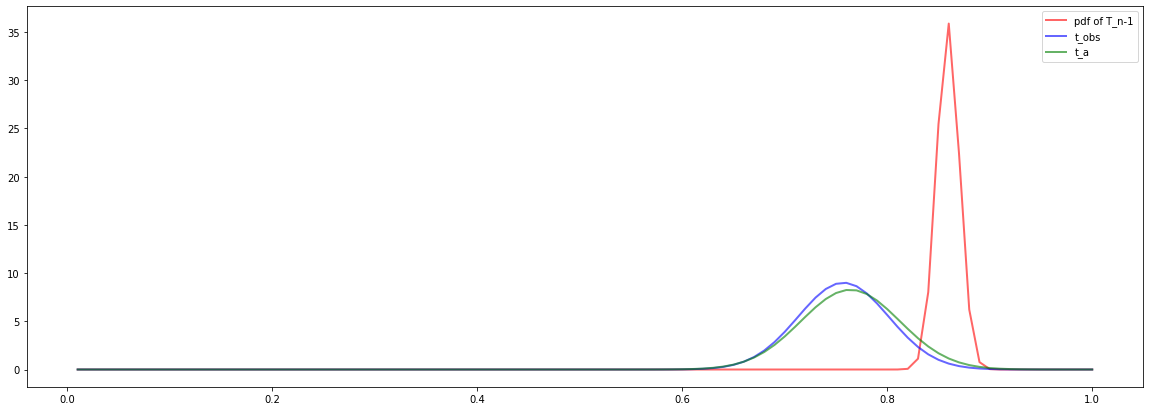

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc



x = np.linspace(0.01,1, 100)

fig = plt.figure(figsize=(20,7))

plt.plot(x, sc.norm.pdf(x,loc=0.859214,scale=0.011093),
        'k-', lw=2, alpha=0.6, label='Training', color='r')

plt.plot(x, sc.norm.pdf(x,loc=0.757231,scale=0.0),
'k-', lw=2, alpha=0.6, label='Validation', color='b')

plt.plot(x, sc.norm.pdf(x,loc=0.763987,scale=0.04823),
'k-', lw=2, alpha=0.6, label='BCR', color='g')

plt.legend(["pdf of T_n-1", "t_obs", "t_a"])